<a href="https://colab.research.google.com/github/REHAB199/Saudi-Arabia-Weather-Deep-learning/blob/main/Code/saudi_arabia_weather_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Import the libraries

 ---

In [116]:
import pandas as pd
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# sklearn 
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import confusion_matrix , precision_score, recall_score, f1_score, \
 roc_auc_score, accuracy_score, classification_report

import random

from yellowbrick.regressor import prediction_error

from imblearn.over_sampling import SMOTE

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout ,BatchNormalization, LSTM, \
 RepeatVector, TimeDistributed, Flatten, SimpleRNN, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Input, Embedding, Activation, \
 CuDNNLSTM, AveragePooling1D 
from keras.models import Model
from keras.callbacks import TensorBoard, Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.initializers import RandomNormal, Constant
from keras.preprocessing.sequence import TimeseriesGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading & reading the data

---

In [7]:
df = pd.read_csv('/content/mkhdata.csv')

In [8]:
df

,Unnamed: 0,city,date,time,year,month,day,hour,minute,weather,temp,wind,humidity,barometer,visibility
0,94805,Mecca,2017-01-01,00:00,2017,1,1,24,0,Clear,22,7,69.0,1016.0,16
1,94806,Mecca,2017-01-01,01:00,2017,1,1,1,0,Clear,21,0,73.0,1015.0,16
2,94807,Mecca,2017-01-01,02:00,2017,1,1,2,0,Clear,21,7,73.0,1015.0,16
3,94808,Mecca,2017-01-01,03:00,2017,1,1,3,0,Clear,21,7,73.0,1015.0,16
4,94809,Mecca,2017-01-01,04:00,2017,1,1,4,0,Clear,21,7,73.0,1015.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20263,115068,Mecca,2019-04-30,19:00,2019,4,30,19,0,Clear,32,15,43.0,1009.0,16
20264,115069,Mecca,2019-04-30,20:00,2019,4,30,20,0,Clear,31,15,46.0,1009.0,16
20265,115070,Mecca,2019-04-30,21:00,2019,4,30,21,0,Clear,30,19,49.0,1010.0,16
20266,115071,Mecca,2019-04-30,22:00,2019,4,30,22,0,Clear,30,15,49.0,1010.0,16


In [9]:
# Unnamed: 0 is irrlevent 
delete_col =['Unnamed: 0']
df.drop(delete_col, axis =1 , inplace =True)

In [10]:
df.shape

(20268, 14)

In [11]:
df.describe()

,year,month,day,hour,minute,temp,wind,humidity,barometer,visibility
count,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000,20268.000000
mean,2017.710480,5.958309,15.681419,12.498076,0.049142,29.023239,13.913312,54.158772,1008.713919,10.711417
std,0.698316,3.511464,8.787419,6.919406,1.198201,4.607044,8.369067,15.479241,4.854478,7.460926
min,2017.000000,1.000000,1.000000,1.000000,0.000000,16.000000,-1.000000,5.000000,996.000000,-1.000000
25%,2017.000000,3.000000,8.000000,7.000000,0.000000,26.000000,7.000000,44.000000,1005.000000,-1.000000
50%,2018.000000,6.000000,16.000000,12.000000,0.000000,29.000000,13.000000,55.000000,1009.000000,16.000000
75%,2018.000000,9.000000,23.000000,18.000000,0.000000,32.000000,19.000000,66.000000,1013.000000,16.000000
max,2019.000000,12.000000,31.000000,24.000000,59.000000,49.000000,163.000000,100.000000,1021.000000,16.000000


In [12]:
df.dtypes

city           object
date           object
time           object
year            int64
month           int64
day             int64
hour            int64
minute          int64
weather        object
temp            int64
wind            int64
humidity      float64
barometer     float64
visibility      int64
dtype: object

## EDA
---

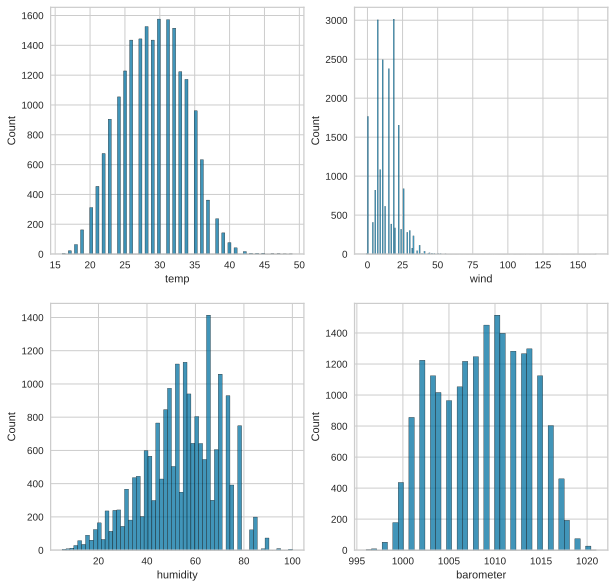

In [13]:
cols_to_plot = ['temp', 'wind', 'humidity', 'barometer']
plt.figure(figsize=(10, 10))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col)

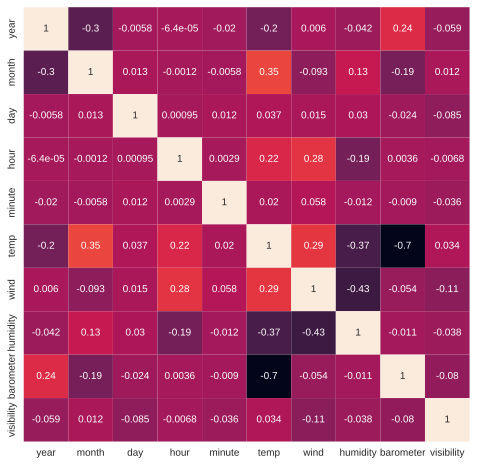

In [14]:
#Plot the correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, cbar=False)
plt.show()

In [15]:
df = pd.get_dummies(df)

In [16]:
df

,year,month,day,hour,minute,temp,wind,humidity,barometer,visibility,city_Mecca,date_2017-01-01,date_2017-01-02,date_2017-01-03,date_2017-01-04,date_2017-01-05,date_2017-01-06,date_2017-01-07,date_2017-01-08,date_2017-01-09,date_2017-01-10,date_2017-01-11,date_2017-01-12,date_2017-01-13,date_2017-01-14,date_2017-01-15,date_2017-01-16,date_2017-01-17,date_2017-01-18,date_2017-01-19,date_2017-01-20,date_2017-01-21,date_2017-01-22,date_2017-01-23,date_2017-01-24,date_2017-01-25,date_2017-01-26,date_2017-01-27,date_2017-01-28,date_2017-01-29,...,time_23:00,time_23:30,weather_Broken Clouds,weather_Clear,weather_Dense Fog,weather_Drizzle Broken Clouds,weather_Duststorm,weather_Extremely Hot,weather_Fog,weather_Haze,weather_Hot,weather_Light Rain Broken Clouds,weather_Light Rain Mostly Cloudy,weather_Light Rain Partly Sunny,weather_Light Rain Passing Clouds,weather_Low Level Haze,weather_Mild,weather_More Clouds Than Sun,weather_Overcast,weather_Partly Cloudy,weather_Partly Sunny,weather_Passing Clouds,weather_Rain Broken Clouds,weather_Rain Partly Sunny,weather_Rain Passing Clouds,weather_Rain Scattered Clouds,weather_Sandstorm,weather_Scattered Clouds,weather_Smoke,weather_Sunny,weather_Thundershowers Partly Sunny,weather_Thundershowers Passing Clouds,weather_Thundershowers Scattered Clouds,weather_Thunderstorms Broken Clouds,weather_Thunderstorms Overcast,weather_Thunderstorms Partly Cloudy,weather_Thunderstorms Partly Sunny,weather_Thunderstorms Passing Clouds,weather_Thunderstorms Scattered Clouds,weather_Warm
0,2017,1,1,24,0,22,7,69.0,1016.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017,1,1,1,0,21,0,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017,1,1,2,0,21,7,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017,1,1,3,0,21,7,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017,1,1,4,0,21,7,73.0,1015.0,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20263,2019,4,30,19,0,32,15,43.0,1009.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20264,2019,4,30,20,0,31,15,46.0,1009.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20265,2019,4,30,21,0,30,19,49.0,1010.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20266,2019,4,30,22,0,30,15,49.0,1010.0,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#plt.figure(figsize=(16,8))
#sns.lineplot(data=df)

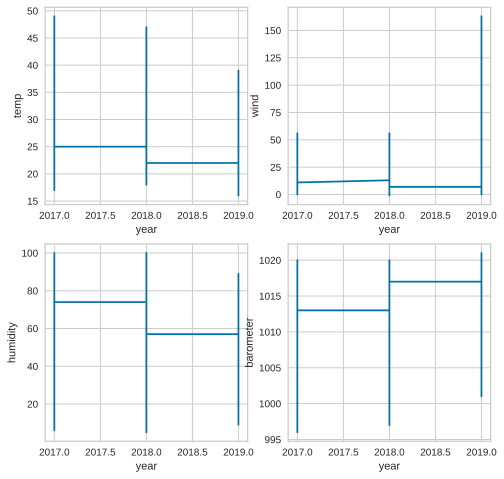

In [19]:
figure, ax = plt.subplots(2, 2, figsize=(8,8))
plt.style.use('seaborn')

ax1 = ax[0]
ax2 = ax[1]

# Plot the Number of Page Loads with time
ax1[0].plot(df['year'], df['temp'])
ax1[0].set_xlabel("year")
ax1[0].set_ylabel("temp")

# Plot the Number of Unique Visits with time
ax1[1].plot(df['year'], df['wind'])
ax1[1].set_xlabel("year")
ax1[1].set_ylabel("wind")

# Plot the Number of First Time visits with time
ax2[0].plot(df['year'], df['humidity'])
ax2[0].set_xlabel("year")
ax2[0].set_ylabel("humidity")

# Plot the Number of Returning visits with time
ax2[1].plot(df['year'], df['barometer'])
ax2[1].set_xlabel("year")
ax2[1].set_ylabel("barometer")

figure.show()

## Split

---

In [20]:
df_Train, df_test = train_test_split(df, test_size=0.2, random_state= 30)

df_train, df_val = train_test_split(df_Train, test_size=0.2, random_state= 30)

## Scaler
---

In [21]:
scaler = StandardScaler()

df_train_scaled =scaler.fit_transform(df_train.values)
df_val_scaled = scaler.transform(df_val.values)
df_test_scaled = scaler.transform(df_test.values)

In [22]:
print(f'Shape of train:', df_train.shape)
print(f'Shape of validation:', df_val.shape)
print(f'Shape of test:', df_test.shape)

Shape of train: (12971, 962)
Shape of validation: (3243, 962)
Shape of test: (4054, 962)


### LinearRegression model

In [23]:
X_train = df_train.drop(["temp"], axis = 1)
y_train = df_train["temp"]
X_val= df_val.drop(['temp'], axis=1)
y_val= df_val['temp']
X_test= df_test.drop(['temp'], axis=1)
y_test= df_test['temp']

In [24]:
print("Length of the X_train = ",len(X_train))
print("Length of the y_train = ",len(y_train))
print("Length of the X_test = ",len(X_test))
print("Length of the y_test = ",len(y_test))
print("Length of the y_val = ",len(y_val))
print("Length of the y_val = ",len(y_val))

Length of the X_train =  12971
Length of the y_train =  12971
Length of the X_test =  4054
Length of the y_test =  4054
Length of the y_val =  3243
Length of the y_val =  3243


In [25]:
lm = LinearRegression().fit(X_train,y_train)
lm.score(X_train,y_train)

0.9568312655748805

In [26]:
px.scatter(
    df_train, x='year', y='temp',opacity=0.4,
    trendline='ols', trendline_color_override='purple',title="Regression line for year and temp "
)

## LSTM Model
---

In [27]:
# Build the LSTM Stack model
model=Sequential()
#Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2)) # Dropout regularisation
#second LSTM layer 
model.add(LSTM(150,return_sequences=True))
#Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
#Adding fourth LSTM layer
model.add(LSTM(150))
model.add(Dropout(0.2))
#Adding the Output Layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 150)          91200     
                                                                 
 dropout (Dropout)           (None, 100, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 150)          180600    
                                                                 
 lstm_2 (LSTM)               (None, 100, 150)          180600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 150)          0         
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0

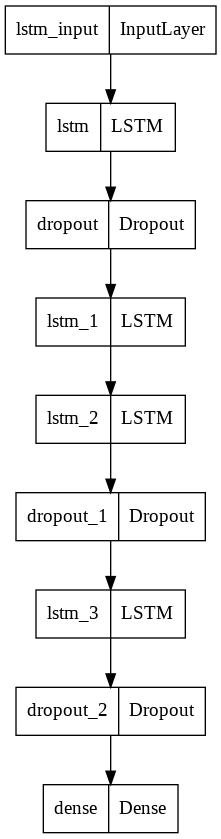

In [29]:
plot_model(model, to_file='model.png')


In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((100, 1), input_shape=(100,)))
# model.output_shape == (None, 100, 1), `None` is the batch size.
model.output_shape


(None, 100, 1)

In [31]:
# #### EROR
# from tensorflow.keras.callbacks import EarlyStopping

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
#         verbose=1, mode='auto', restore_best_weights=True)

# history=model.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=1,epochs=1000)


In [ ]:
#log_cfl = LogisticRegression(C=0.95, random_state=0)

#log_cfl.fit(X_train, y_train)

#y_predict = log_cfl.predict(X_train)

# evaluate the model
#print(classification_report(X_train, y_predict))
#print(confusion_matrix(X_train, y_predict))

In [ ]:
#regr = linear_model.Ridge(alpha= 0.5)
#regr.fit(X_train,y_train)

#y_pred = regr.predict(df_test)
#y_pred

## RNN 
---

In [34]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

In [35]:
n_input = (100,1)

In [36]:
# error
train_generator = TimeseriesGenerator(df_train_scaled ,df_train_scaled, length=n_input, batch_size=32)

TypeError: ignored

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 64)           16896     
                                                                 
 lstm_5 (LSTM)               (None, 100, 32)           12416     
                                                                 
 lstm_6 (LSTM)               (None, 100, 16)           3136      
                                                                 
 lstm_7 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33,257
Trainable params: 33,257
Non-trainable params: 0
_________________________________________________________________


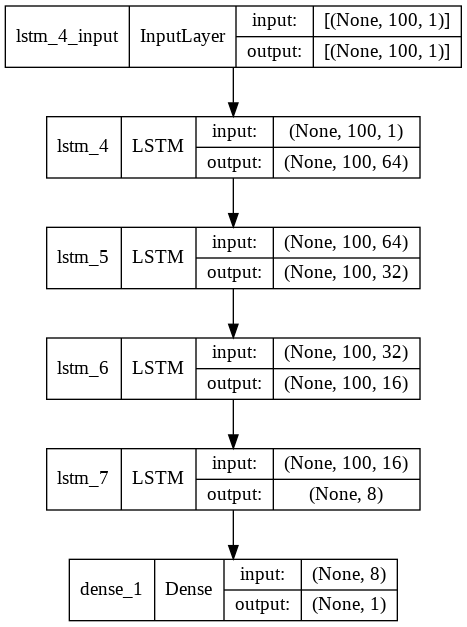

In [37]:
model = Sequential()

model.add(LSTM(64, input_shape= ((100,1)), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()
plot_model(model, show_shapes=True)

In [38]:
history = model.fit_generator(train_generator, callbacks=[es, ckpt, rlp], epochs=100)
pd.DataFrame(history.history)[['loss']].plot();

NameError: ignored

## CNN Model
---

In [39]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (12971, 961, 1)
Validation set shape (3243, 961, 1)


In [40]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 960, 64)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 480, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                1536050   
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,536,293
Trainable params: 1,536,293
Non-trainable params: 0
____________________________________________

In [41]:
cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, verbose=2)

Epoch 1/40
406/406 - 17s - loss: 29.1980 - val_loss: 9.1188 - 17s/epoch - 43ms/step
Epoch 2/40
406/406 - 16s - loss: 6.7178 - val_loss: 2.8622 - 16s/epoch - 40ms/step
Epoch 3/40
406/406 - 16s - loss: 3.7142 - val_loss: 1.6817 - 16s/epoch - 39ms/step
Epoch 4/40
406/406 - 16s - loss: 2.7632 - val_loss: 1.4903 - 16s/epoch - 40ms/step
Epoch 5/40
406/406 - 16s - loss: 3.2656 - val_loss: 1.6550 - 16s/epoch - 40ms/step
Epoch 6/40
406/406 - 16s - loss: 2.8933 - val_loss: 17.7998 - 16s/epoch - 39ms/step
Epoch 7/40
406/406 - 16s - loss: 2.4654 - val_loss: 1.5475 - 16s/epoch - 40ms/step
Epoch 8/40
406/406 - 16s - loss: 2.3491 - val_loss: 2.2312 - 16s/epoch - 40ms/step
Epoch 9/40
406/406 - 16s - loss: 2.2987 - val_loss: 1.1757 - 16s/epoch - 40ms/step
Epoch 10/40
406/406 - 16s - loss: 2.7038 - val_loss: 4.0535 - 16s/epoch - 39ms/step
Epoch 11/40
406/406 - 16s - loss: 1.9727 - val_loss: 1.1388 - 16s/epoch - 40ms/step
Epoch 12/40
406/406 - 16s - loss: 2.0463 - val_loss: 2.7861 - 16s/epoch - 40ms/step

## LSTM Model2

---

In [42]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [44]:
lstm_history = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=2)

Epoch 1/5
406/406 - 174s - loss: nan - val_loss: nan - 174s/epoch - 429ms/step
Epoch 2/5
406/406 - 171s - loss: nan - val_loss: nan - 171s/epoch - 420ms/step
Epoch 3/5
406/406 - 172s - loss: nan - val_loss: nan - 172s/epoch - 422ms/step
Epoch 4/5
406/406 - 175s - loss: nan - val_loss: nan - 175s/epoch - 431ms/step
Epoch 5/5
406/406 - 174s - loss: nan - val_loss: nan - 174s/epoch - 428ms/step


## CNN-LSTM 
---

In [45]:
## error
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_val_sub = X_val.reshape((X_val_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_sub.shape)
print('Validation set shape', X_val_sub.shape)

AttributeError: ignored

In [47]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

NameError: ignored

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_sub, y_train, validation_data=(X_val_sub, y_val), epochs=3, verbose=2)

## Bi-directional LSTM

Adding Bi-directional wrapper around LSTM

---

In [98]:
es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

def get_model_bilstm(shape=(19,22)):
    inp = Input(shape)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(inp)
    x = TimeDistributed(Dense(10))(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    return model

In [99]:
model_bi = get_model_bilstm((19,22))
model_bi.compile(optimizer='adadelta', loss='mae')
model_bi.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 19, 22)]          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 19, 128)          45056     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 19, 10)           1290      
 tributed)                                                       
                                                                 
 flatten_7 (Flatten)         (None, 190)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 191       
                                                                 
Total params: 46,537
Trainable params: 46,537
Non-trainable

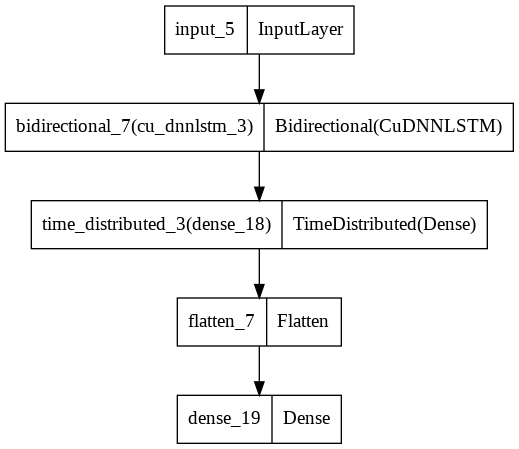

In [100]:
plot_model(model_bi, to_file='model_bi1.png')

In [96]:
# model_bi.fit(X_train, y_train, validation_data=(X_val, y_val),
#              epochs=300, batch_size=128)

In [95]:
# y_pred_bi = model_bi.predict(X_test)


In [94]:
# submission_bi = pd.DataFrame({'Id': test_ids, 'Expected': y_pred_bi.reshape(-1)})
# submission_bi.to_csv('submission_2.csv', index=False)

In [101]:
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model_bi = Sequential()
model_bi.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model_bi.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_bi.add(MaxPooling1D(pool_size=2))
model_bi.add(Flatten())
model_bi.add(RepeatVector(30))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(Dropout(0.2))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(Dropout(0.2))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_bi.add(Bidirectional(LSTM(128, activation='relu')))
model_bi.add(Dense(100, activation='relu'))
model_bi.add(Dense(1))
model_bi.compile(loss='mse', optimizer='adam')

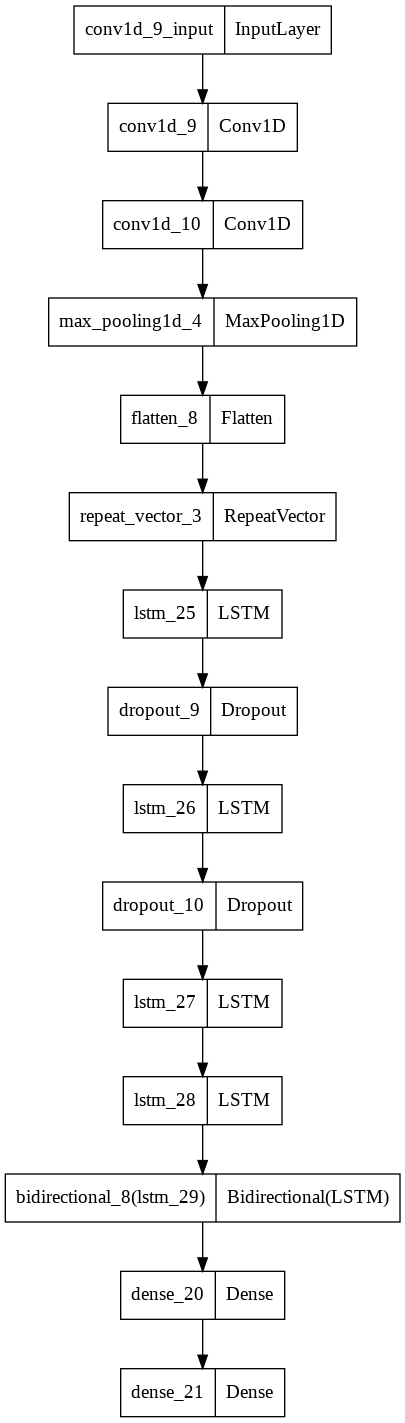

In [102]:
plot_model(model_bi, to_file='model_bi2.png')

In [93]:
# model_bi.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, verbose=2)

In [92]:
# history = model_bi.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=300, verbose=1, callbacks = [early_stop] )


In [107]:
# split a univariate sequence into samples
def split_sequence(sequence,n_steps):
    X,y = list(),list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_idx = i+n_steps
        # Check if we are beyond the sequence 
        if end_idx  > len(sequence)-1:
            break
        # gather i/o parts of the pattern
        seq_x,seq_y = sequence[i:end_idx],sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X),array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print('Prediction score: ', yhat)

Prediction score:  [[102.04194]]


In [ ]:
## EVERY THING IN COMMENTED CELL IN THIS SECTION HAVE AN ERROR 